## Report for photovoltaic system data analysis

### Introduction
The goal of this project is to analyze the data from a household photovoltaic system. It has been two years since the system was installed, and the data has been collected since then. So we think it could be interesting to look at these data and try to analyze them and put them into context of weather data collected in the same period.

### Planned steps

### Data description
The data includes information about the household overall energy consumption, photovoltaic system production, battery and daily sunlight duration, average temperature, and irradiation. In case of the household energy related data it is collected form year 2022 to 2024. The weather data is collected from year 2022 to 2023.

#### Data sources
Energy related data were collected by app provided by the photovoltaic system manufacturer. So we can assume that the data are accurate and reliable.

Weather data were collected from the Czech Hydrometeorological Institute. In case of the sunlight data and the temperature data, they were collected from weather station that is only 7 km away from the household. So their relevance and accuracy can be considered as high.

In case of the irradiation data, it was collected from the weather station that is 25 km away from the household, so there could be some questions about the relevance of the data but their accuracy can once again be considered as high.

#### Data preprocessing



In [4]:
import pandas as pd

import pandas as pd

# Define pairs of sheet names and data types
sheet_data_pairs = {
    'Přehled': 'Consumption',
    # 'Baterie': 'Battery'
}

folder_path = 'Tables'
first_year = 2022
year_count = 3

for sheet_name, data_type in sheet_data_pairs.items():
    data = []
    for i in range(year_count):
        data.append(pd.read_excel(f"{folder_path}/{data_type}-{first_year+i}.xlsx", sheet_name=sheet_name, header=None))

    # Define table headers to identify each table
    headers = []
    if data_type == 'Consumption':
        headers = [
            ["Měsíc", "Zátěž [kWh]", "Síť [kWh]", "Výkon FVE [kWh]"],
            ["Den", "Zátěž [Wh]", "Síť [Wh]", "Výkon FVE [Wh]"],
            ["Čas", "Zátěž [Wh]", "Síť [Wh]", "Výkon FVE [Wh]"]
        ]
    elif data_type == 'Battery':
        headers = [
            ["Měsíc", "Kapacita [%]", "Teplota [°C]"],
            ["Den", "Kapacita [%]", "Teplota [°C]"],
            ["Čas", "Napětí [V]", "Proud [A]"]
        ]

    # Function to find where a specific table starts
    def find_table_start(df, header_row):
        for i in range(len(df)):
            if df.iloc[i, :len(header_row)].tolist() == header_row:
                return i
        return -1

    # Extract each table based on its header
    tables = []
    for data in data:
        for i in range(len(headers)):
            start_index = find_table_start(data, headers[i])
            end_index = find_table_start(data, headers[i+1]) if i+1 < len(headers) else len(data)
            if start_index != -1:
                # Extract the table
                table = data.iloc[start_index+1:end_index]  # Skip the header itself
                table.columns = data.iloc[start_index]  # Set the header row
                table = table.dropna(how='all', axis=0)  # Drop rows that are completely empty
                table = table.dropna(how='all', axis=1)  # Drop columns that are completely empty
                tables.append(table)
            else:
                print(f"Header {headers[i]} not found!")

    # Merge tables with the same headers in correct order
    for i in range(year_count):
        for j in range(len(headers)):
            if i == 0 and j == 0:
                continue
            tables[j] = pd.concat([tables[j], tables[j + len(headers) * i]], ignore_index=True)

    tables = tables[:len(headers)]

    monthly_data, daily_data, hourly_data = tables

    # Display the first few rows of each table
    # print("Monthly Data:")
    # print(monthly_data.head())
    #
    # print("\nDaily Data:")
    # print(daily_data.head())
    #
    # print("\nHourly Data:")
    # print(hourly_data.head())
    #
    # Save tables to CSV files
    # monthly_data.to_csv(f"{folder_path}/monthly_{data_type.lower()}.csv", index=False)
    # daily_data.to_csv(f"{folder_path}/daily_{data_type.lower()}.csv", index=False)
    # hourly_data.to_csv(f"{folder_path}/hourly_{data_type.lower()}.csv", index=False)

daily_data

,Den,Zátěž [Wh],Síť [Wh],Výkon FVE [Wh]
0,5/4/2022,0,48,0
1,8/4/2022,12093,10822,49
2,9/4/2022,23335,8043,21758
3,10/4/2022,22733,3856,32728
4,11/4/2022,25084,5719,25168
...,...,...,...,...
1172,12/10/2024,33500,19388,19008
1173,13/10/2024,20605,-374,29268
1174,14/10/2024,12782,-11806,31542
1175,15/10/2024,9539,-24645,43041


In [26]:
import pandas as pd

file_path = 'Tables/sunlight-original.csv'
# file_path = 'Tables/Irradiation-original.csv'
# file_path = 'Tables/temperature-original.csv'

org_sep = ';'
first_year = 2022

# load data
data = pd.read_csv(file_path, sep=org_sep)

# print(data.head())

# delete rows from before the first year
data = data[data['Rok'] >= first_year]

# print(data.head())

# transform data
org_header = ['Rok', 'Měsíc', 'Den', 'Poznámka']

new_header = ['Date', 'Value'] # date format: dd/mm/yyyy
new_sep = ','

data['Date'] = data['Den'].astype(str) + '/' + data['Měsíc'].astype(str) + '/' + data['Rok'].astype(str)
data = data.drop(columns=org_header)
data = data.rename(columns={'Hodnota': 'Value'})
data = data[new_header]

data.to_csv(file_path.replace('original', 'transformed'), index=False, sep=new_sep)

#### Preprocessed data description

### Exploratory analysis
#### Monthly energy consumption visualization


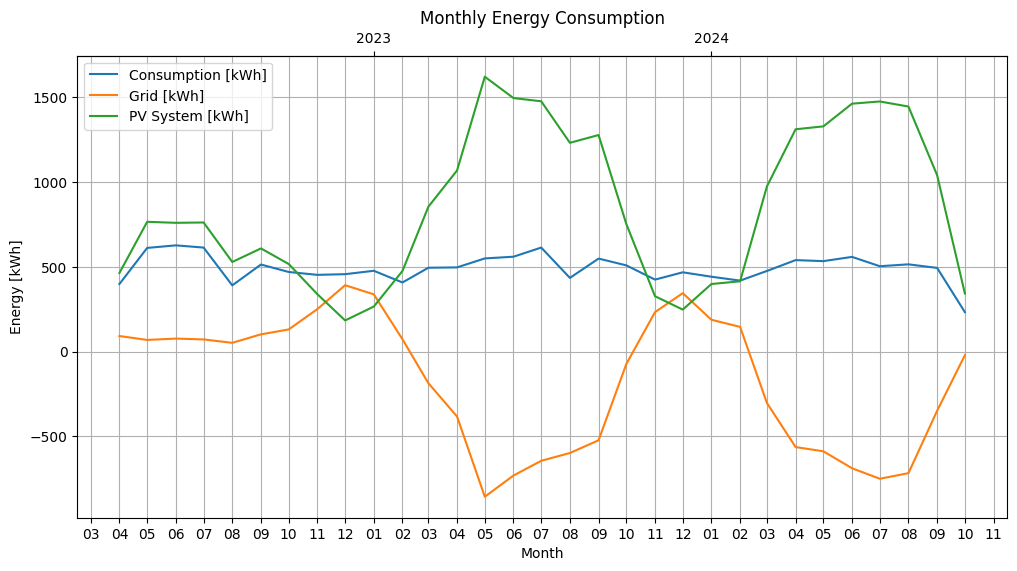

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
file_path = 'Tables/monthly_consumption.csv'
data = pd.read_csv(file_path)

# Convert 'Měsíc' to datetime
data['Měsíc'] = pd.to_datetime(data['Měsíc'], format='%m/%Y')

# Plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['Měsíc'], data['Zátěž [kWh]'], label='Consumption [kWh]')
ax.plot(data['Měsíc'], data['Síť [kWh]'], label='Grid [kWh]')
ax.plot(data['Měsíc'], data['Výkon FVE [kWh]'], label='PV System [kWh]')

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Energy [kWh]')
ax.set_title('Monthly Energy Consumption')
ax.legend()
ax.grid()

# Format the x-axis to show months and years
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.xaxis.set_minor_locator(mdates.YearLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))

# Add a secondary x-axis for the years
secax = ax.secondary_xaxis('top')
secax.xaxis.set_major_locator(mdates.YearLocator())
secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show the plot
plt.show()



#### Monthly PV system production in context of irradiation for year 2023 visualization


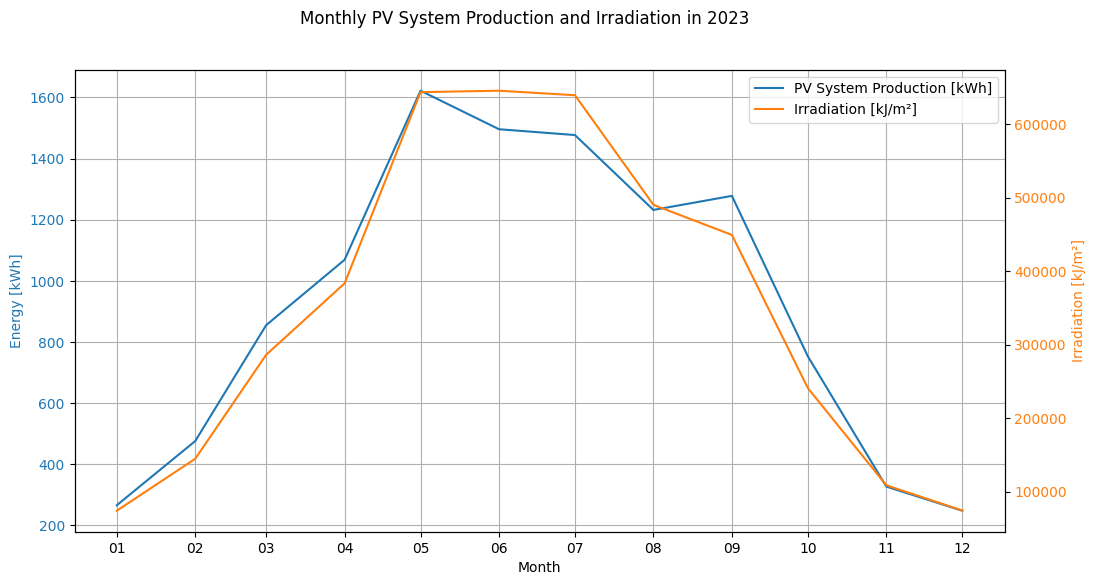

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
production_file_path = 'Tables/monthly_consumption.csv'
irradiation_file_path = 'Tables/Irradiation-transformed.csv'

production_data = pd.read_csv(production_file_path)
irradiation_data = pd.read_csv(irradiation_file_path)

# Convert 'Měsíc' to datetime and filter for the year 2023
production_data['Měsíc'] = pd.to_datetime(production_data['Měsíc'], format='%m/%Y')
production_data_2023 = production_data[production_data['Měsíc'].dt.year == 2023]

# Convert 'Date' to datetime and filter for the year 2023
irradiation_data['Date'] = pd.to_datetime(irradiation_data['Date'], format='%d/%m/%Y')
irradiation_data = irradiation_data.set_index('Date')
irradiation_data_2023 = irradiation_data[irradiation_data.index.year == 2023]

# Sum irradiation values for each month in 2023
irradiation_data_2023 = irradiation_data_2023.resample('MS').sum()

# Plot data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot PV System Production
ax1.plot(production_data_2023['Měsíc'], production_data_2023['Výkon FVE [kWh]'], label='PV System Production [kWh]', color='tab:blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy [kWh]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for Irradiation
ax2 = ax1.twinx()
ax2.plot(irradiation_data_2023.index, irradiation_data_2023['Value'], label='Irradiation [kJ/m²]', color='tab:orange')
ax2.set_ylabel('Irradiation [kJ/m²]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set title and grid
fig.suptitle('Monthly PV System Production and Irradiation in 2023')
ax1.grid()

# Format the x-axis to show only the months of 2023
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88))

# Show the plot
plt.show()

